
---
title: "Cross-Sectional Survey Designs"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

Notes for Chapter 3 of [Causal Inference with Survey Data](https://www.linkedin.com/learning/causal-inference-with-survey-data/surveys-with-cross-sectional-data?autoSkip=true&resume=false&u=185169545) on LinkedIn Learning, given by Franz Buscha. I'm using this series of posts to take some notes.

In [1]:
import graphviz as gr

In [2]:
def draw_causal_graph(
    edge_list, node_props=None, edge_props=None, graph_direction="UD"
):
    """Utility to draw a causal (directed) graph
    Taken from: https://github.com/dustinstansbury/statistical-rethinking-2023/blob/a0f4f2d15a06b33355cf3065597dcb43ef829991/utils.py#L52-L66

    """
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

# Cross-sectional survey designs

- It's a snapshot in time, capturing information from many subjects.
- Most common type of survey.

**Examples**
1. Census surveys. Provides a snapshot of a country's population (e.g. US Census done every 10 years).
1. Expenditure surveys. Information on buying habits (e.g. annual Consumer Expenditure Survey).
1. Labor force surveys. Collect data on employment (e.g. UK Labour Force Survey, conducted quarterly).

**Advantages**
- Availability
- Cheap to conduct
- Versatility in topics

**Disadvantages**
- Lack temporal data
- Sampling, selection, and response bias
- Lack of depth (limited data on complex issues)

**Statistical Framework**
- A key to working with cross-sectional data is the $i$ subscript, such as in the form:

$$ Y_i = \beta_0 + \beta_1X1_i + \beta_2X2_i + ... \epsilon_i$$

- The $i$ denotes different observations in the data (e.g. subjects or entities at a single point in time)

**Conclusion**
- Broad application and more themes.
- Explanatory variables must be used in innovative ways for cause-and-effect analysis.

# Regression analysis

- A fundamental statistical method
- A powerful tool for controlling observable factors
- Mainstay of causal analysis

**DAG: Controlling for Observable Factors**

- A regression model can answer this question: What is the causal effect of X on Y?



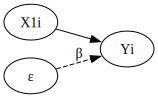

In [3]:
draw_causal_graph(
    edge_list=[("X1i", "Yi"), ("&#x03B5;", "Yi")],
    edge_props={("&#x03B5;", "Yi"): {"style": "dashed", "label": "&beta;"}},
    graph_direction="LR",
)

Other factors that are not seen in the survey data are summed up in the hidden error term.

$ Y_i = \beta_0 + \beta_1X1_i + \epsilon_i $

- Regression can control for many observable factors
- Effects estimated in a regression model are independent of other effects in the model
- Causal infrence relies on there being no confounders (exogeneity assumption)
- Variables that don't gice a choice are often exogenous (sex, age, parents birthplace, etc.). These are variables that are "hard to influence".
- Assumption of exogeneity can be difficult. There can be many factors that drive both Y and X1. This creates a backdoor pathway.


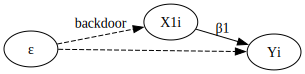

In [4]:
# `&#x03B5;` is unicode for epsilon since `&epsilon;` fails to render
draw_causal_graph(
    edge_list=[("X1i", "Yi"), ("&#x03B5;", "Yi"), ("&#x03B5;", "X1i")],
    edge_props={
        ("X1i", "Yi"): {"label": "&beta;1"},
        ("&#x03B5;", "Yi"): {"style": "dashed"},
        ("&#x03B5;", "X1i"): {"style": "dashed", "label": "backdoor"},
    },
    graph_direction="LR",
)

If the backdoor is present, then the estimate of $\beta_1$ will not be correct.

But imagine that $X2i$ in the error term can be observed. A new DAG might look like this.

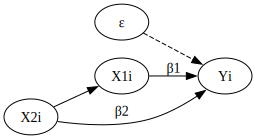

In [5]:
draw_causal_graph(
    edge_list=[("X1i", "Yi"), ("&#x03B5;", "Yi"), ("X2i", "X1i"), ("X2i", "Yi")],
    edge_props={
        ("X1i", "Yi"): {"label": "&beta;1"},
        ("X2i", "Yi"): {"label": "&beta;2"},
        ("&#x03B5;", "Yi"): {"style": "dashed"},
        ("&#x03B5;", "X1i"): {"style": "dashed", "label": "backdoor"},
    },
    graph_direction="LR",
)

$ Y_i = \beta_0 + \beta_1X1_i + \beta_2X2_i + \epsilon_i $

$X2$ is now specifically controlled for.

Triangular Tables:
A way to observe the effect on a regression model of incrementally adding more variables but be careful of overfitting. Knowing what variables to include requires some domain knowledge.

**Advantages**
- Flexibility in variables
- Many different forms for different data
- Easy to understand

**Disadvantages**
- Often too simple
- Cannot control for unobserved confounders

**Conclusion**
- Don't dismiss basic regression
- Underpins more complex models
- Works well with large surveys and many variables

# Propensity score matching

Introduction
- Matching designs achieve causal inference by pairing similar data units.
- They don't require functional form assumptions of normal regression models.
- In normal regression models, coefficients are assumed to be linear. But for something like an age-variable where trends can reverse with old age, this wouldn't be accurate. Sometimes you can address this in a regression model (e.g. spline?) but needs to be done manually and needs to be correct.
- Matching designs overcome this by not needing functional form assumptions.

How does matching work?
- Imagine you want to know the causal effect of a training program on productivity. In an ideal world, you'd have parallel universes where the exact same person is observed with and without the training.
- But with survey data, imagine there are two people who share similar characteristics (age, gender, etc.) except for whether they got training.
- Take the difference in the outcome variable (productivity). Repeat for all possible pairs.
- Take average of all these differences and that's the causal effect based on matching.
- Major advantage of this method: all these micro-comparisons don't require any complex modeling.

Matching assumptions (need both)
- Conditional independence assumption (CIA)
    - Once you control for relevant observed variables, the assignment to the treatment group is as good as random.
    - No unobserved confounders! Can't have unobserved variables that drive both outcome and treatment.
- Common support assumption (CSA)
    - There must be enough appropriate control observations to match wtih.
    - There must be substantial overlap in the distributions of the matching variables comparing the treated and control observations.

Propensity score matching
- Exact matching is when units are paired exactly.
- It's simple but likely reduces dataset a lot. Also leads to the curse of dimensionality.
- You can match on probability of receiving treatment instead. This is called propensity score matching which is the most common type of matching.

## How to propensity score match
1. Model probability of treatment using logit or probit regression with independent variables that you believe influence treatment and outcome.
1. Predict each unit's probability of treatment (e.g. compare the propensity score distribution support between treatments and make sure they're not radically different).
1. Use a matching algorithm to match units. K-nearest neighbors is the most common algorithm.
1. Assess the covariate balance between treated and untreated control groups. Make sure there's not a heavy bias. Check that matched differences all go towards zero.
1. Compare the outcome variable across the matched pairs.


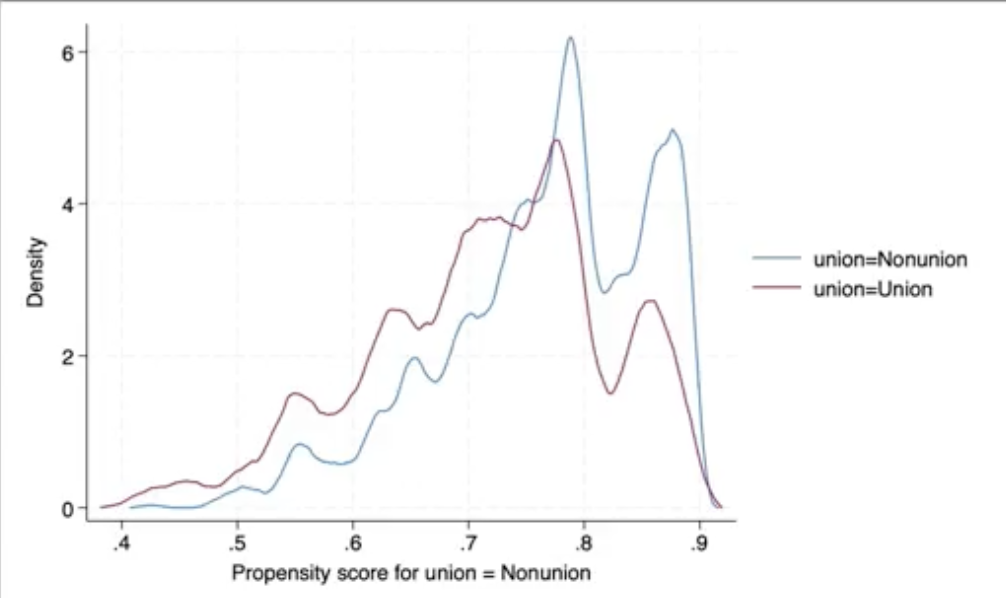


**Advantages**
- More flexible than regression
- Simpler interpretation

**Disadvantages**
- Relies on observable covariates (unobservable covariates can't be helped)
- Matching quality depends on data

**Conclusion**
- Attractive alternative to standard regression
- Relatively easy to impelement and explain
- Requires high-quality data


# Regression discontinuity designs

Introduction
- Exploits a cutoff in the assignment of treatment
- Uses naturally occurring thresholds
- Very useful for policy analysis

Visual technique
- RDD is a very visual technique
- Much of the math is related to curves are fitted on a graph
- Easy to explain

Example: raising of the school leaving age (1972)
- School leaving age increased from 15 to 16
- Reform led to a signficant increase in percentage of kids staying in school (the discontinuity observed before and after reform date)
- Researcher finds the gap between the regression lines before and after the reform

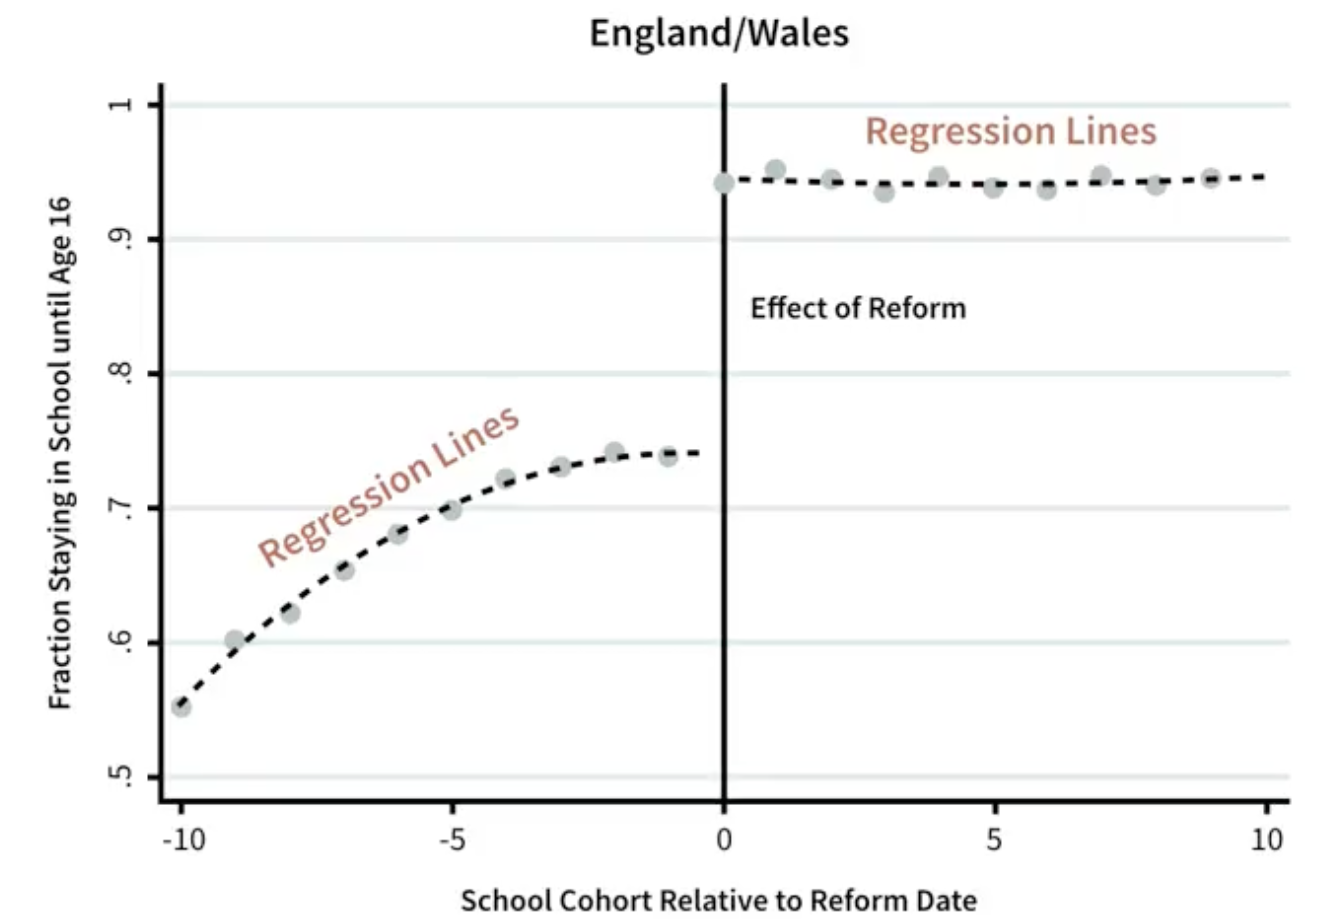

Then what? How do you use discontinuity if you find one? Look another outcome.
- How are average wages changed with more schooling? He sees a positive causal effect on wages.

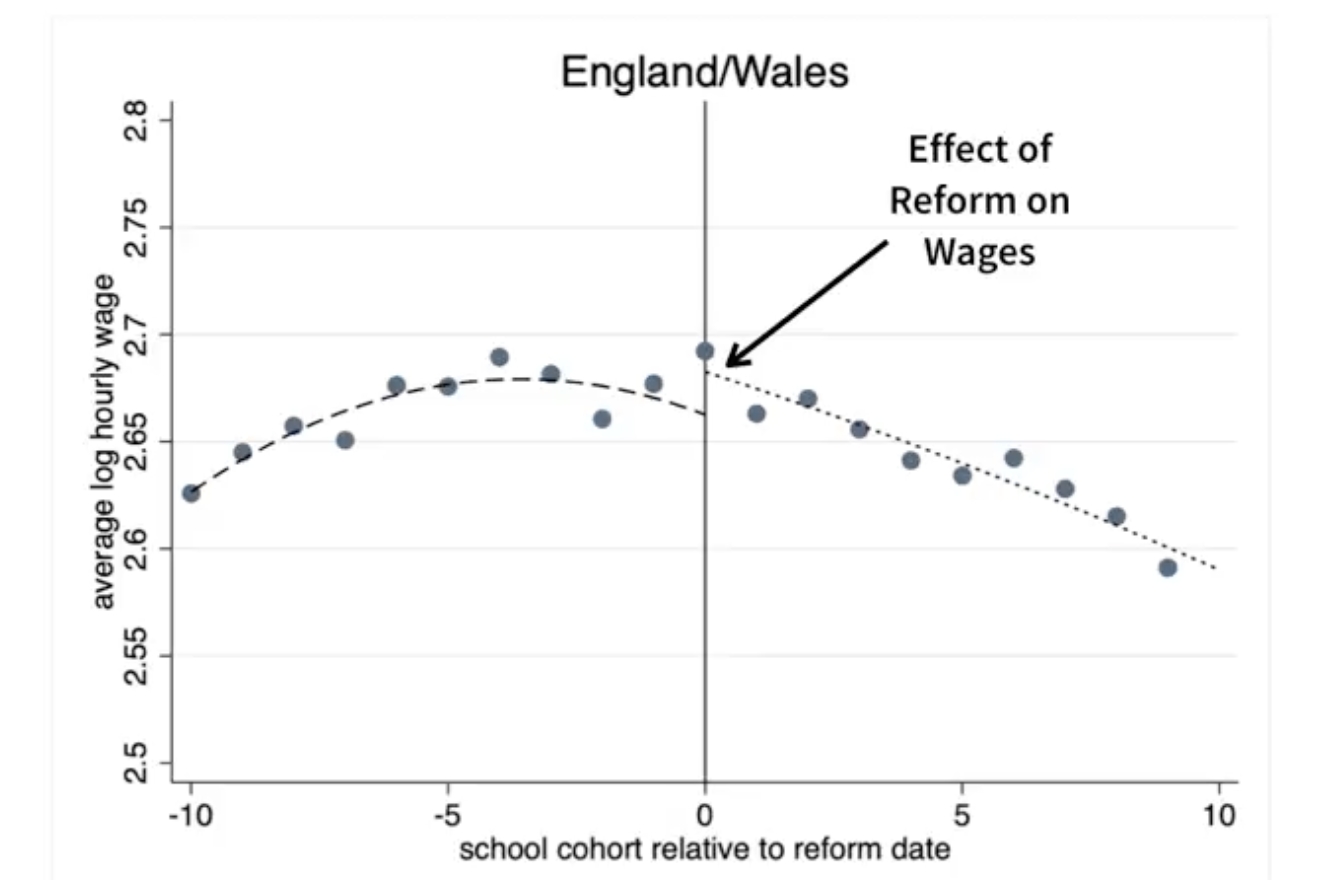



Why causal?
- Placement near discontinuity is random
- Being born just before a reform is random
- Earning just below benefit threshold is random
- RDD can eliminate selection bias into treatments
- It eliminates backdoor paths
- The focus on the cutoff leads to random assignment on just either side of the discontinuity

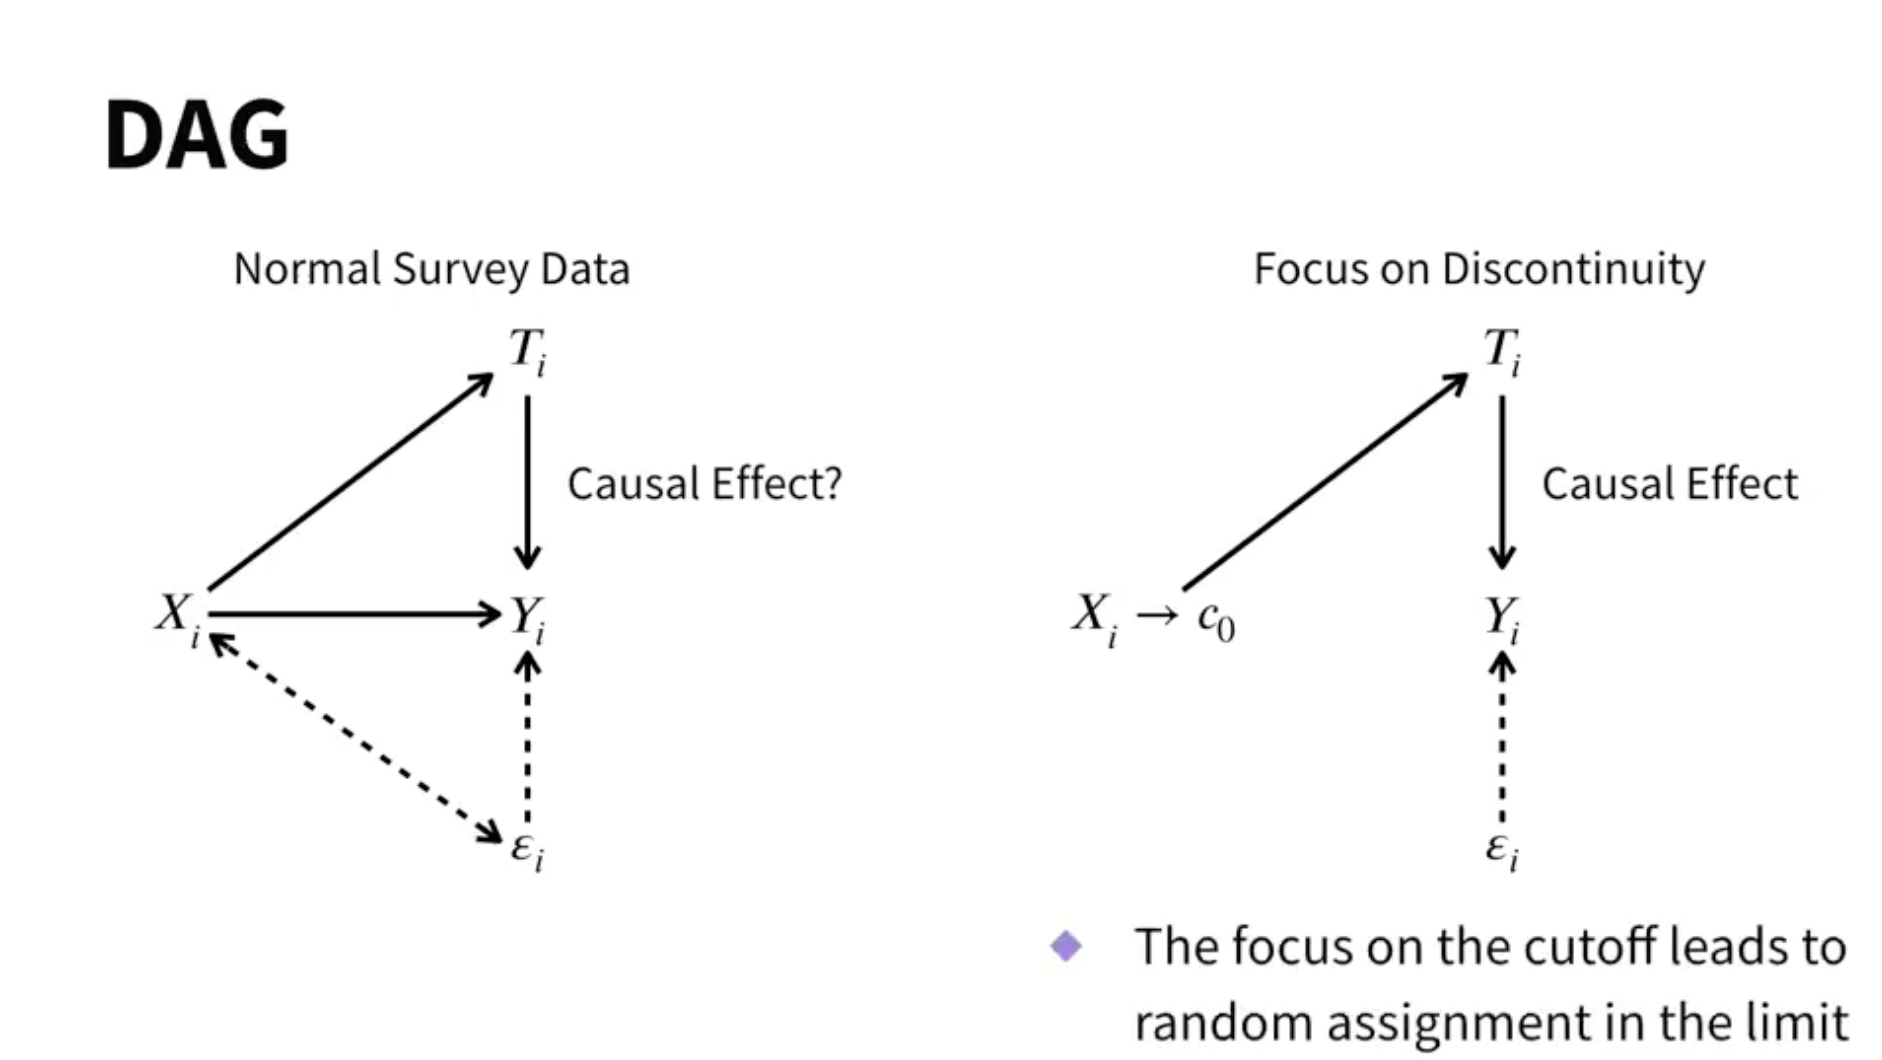


How to perfom RDD?
1. Identify running variable X and natural cut-point (test scores, time of policy interventions, etc.)
1. Use visual and statistical tests to see if discontinuity actually exists (is there a gap in the data)
1. Identify a suitable outcome variable Y that you're interested in
1. Plot Y against X and examine the effect at the discontinuity (parametric vs. non-parametric). Estimate the treatment effect by plotting the difference in Y for either side of the discontinuity. Use parametric methods if you want to control for covariates and may not have a lot of data, or parametric if there's a lot of data but don't want to impose functional form.

Example: election
You can also run multiple RDD lines.



**Advantages**
- Strong causal inference
- Simple and visual

**Disadvantages**
- Generlizability, only applies in vinity of discontinuity
- Many RDD designs are fuzzy, there might be a gradual change instead of a sharp one. That means it's a local average treatment effect (LATE), again limiting generalizability.
- Requires large, high-quality surveys
- Sensitive to specifications

**Conclusion**
- RDD is simple and attractive
- Relies on finding jumps in data
- If they don't exist, find another method.


# Instrumental variables

- Helps causal inference
- Approach requires "instrument"



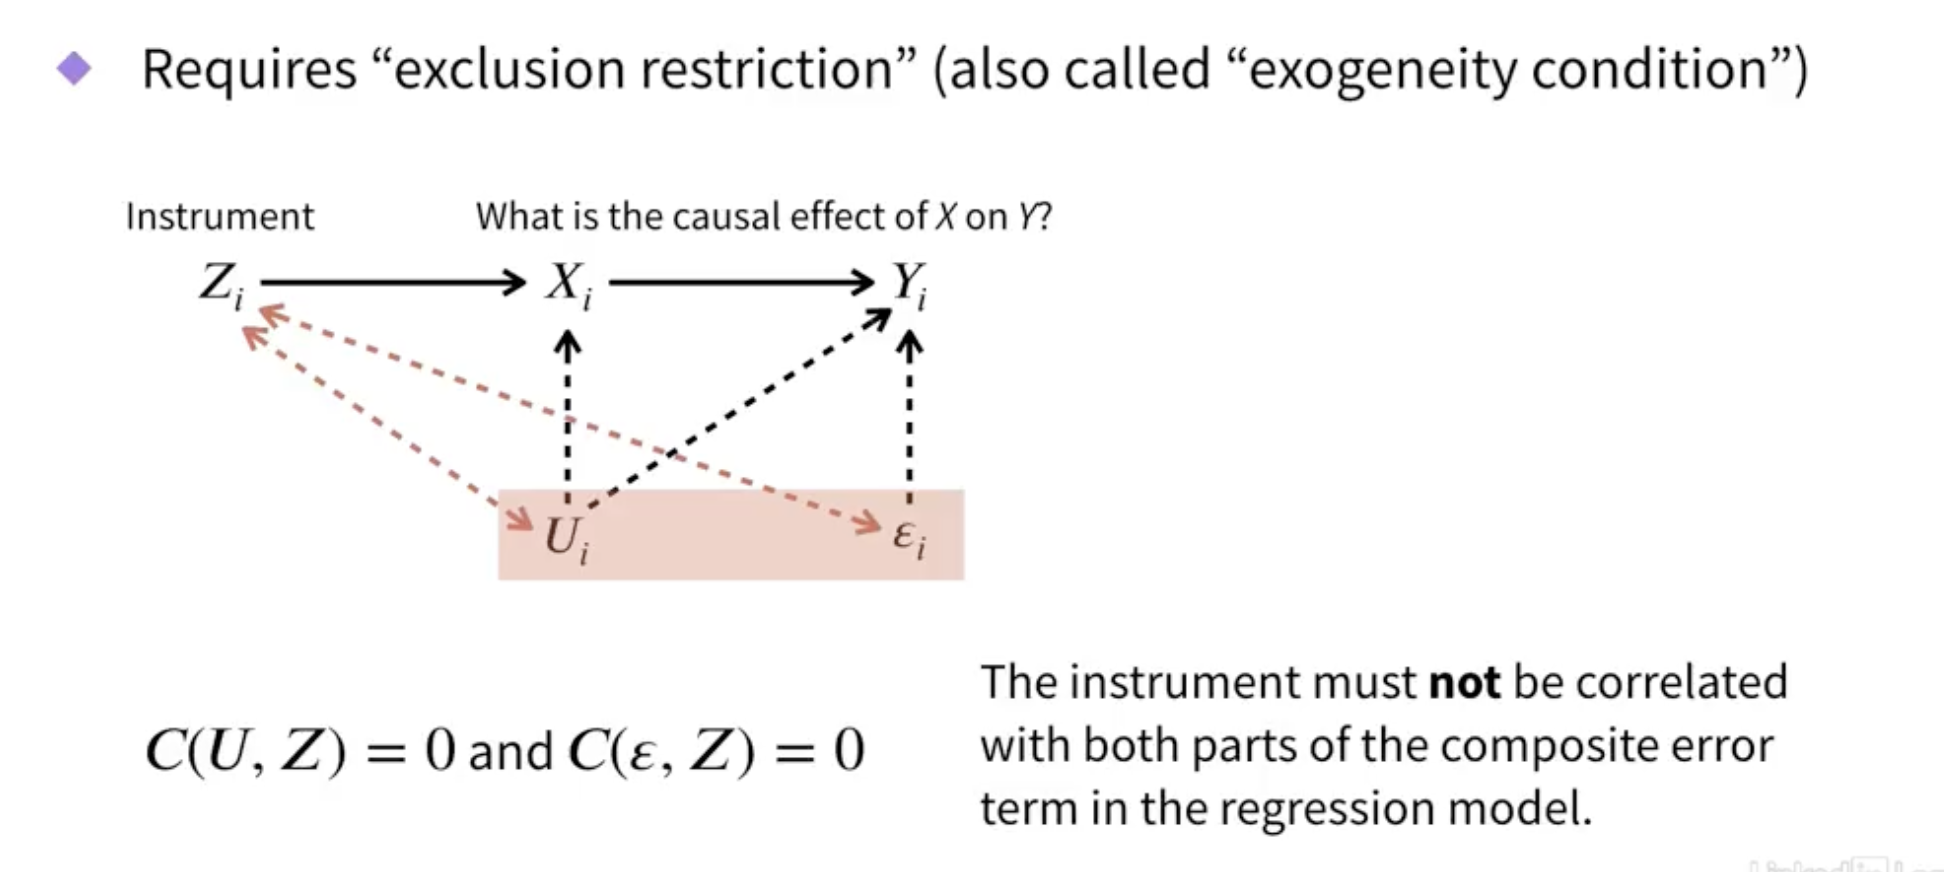



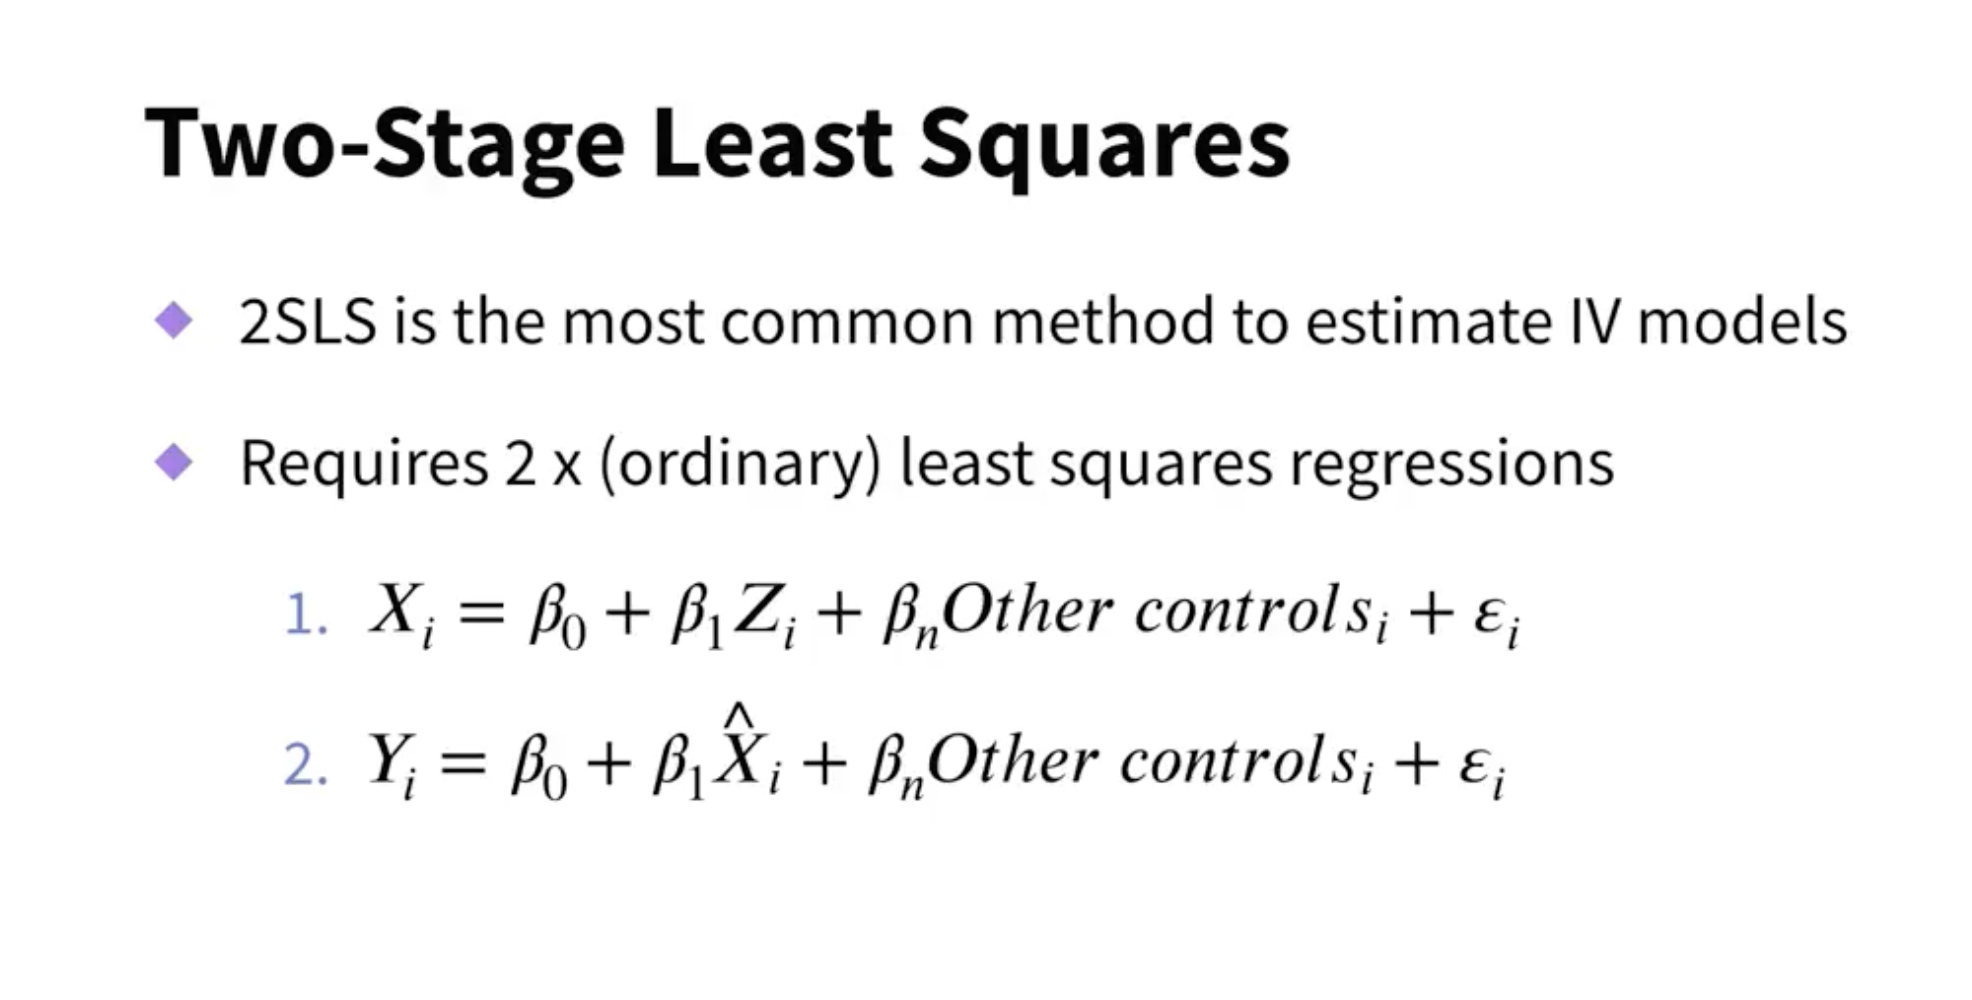

Use the predicted X variable in the second equation, not the actual X variable.

It's tricky to do this manually since some correction needs to take place.

Always use a dedicated program.


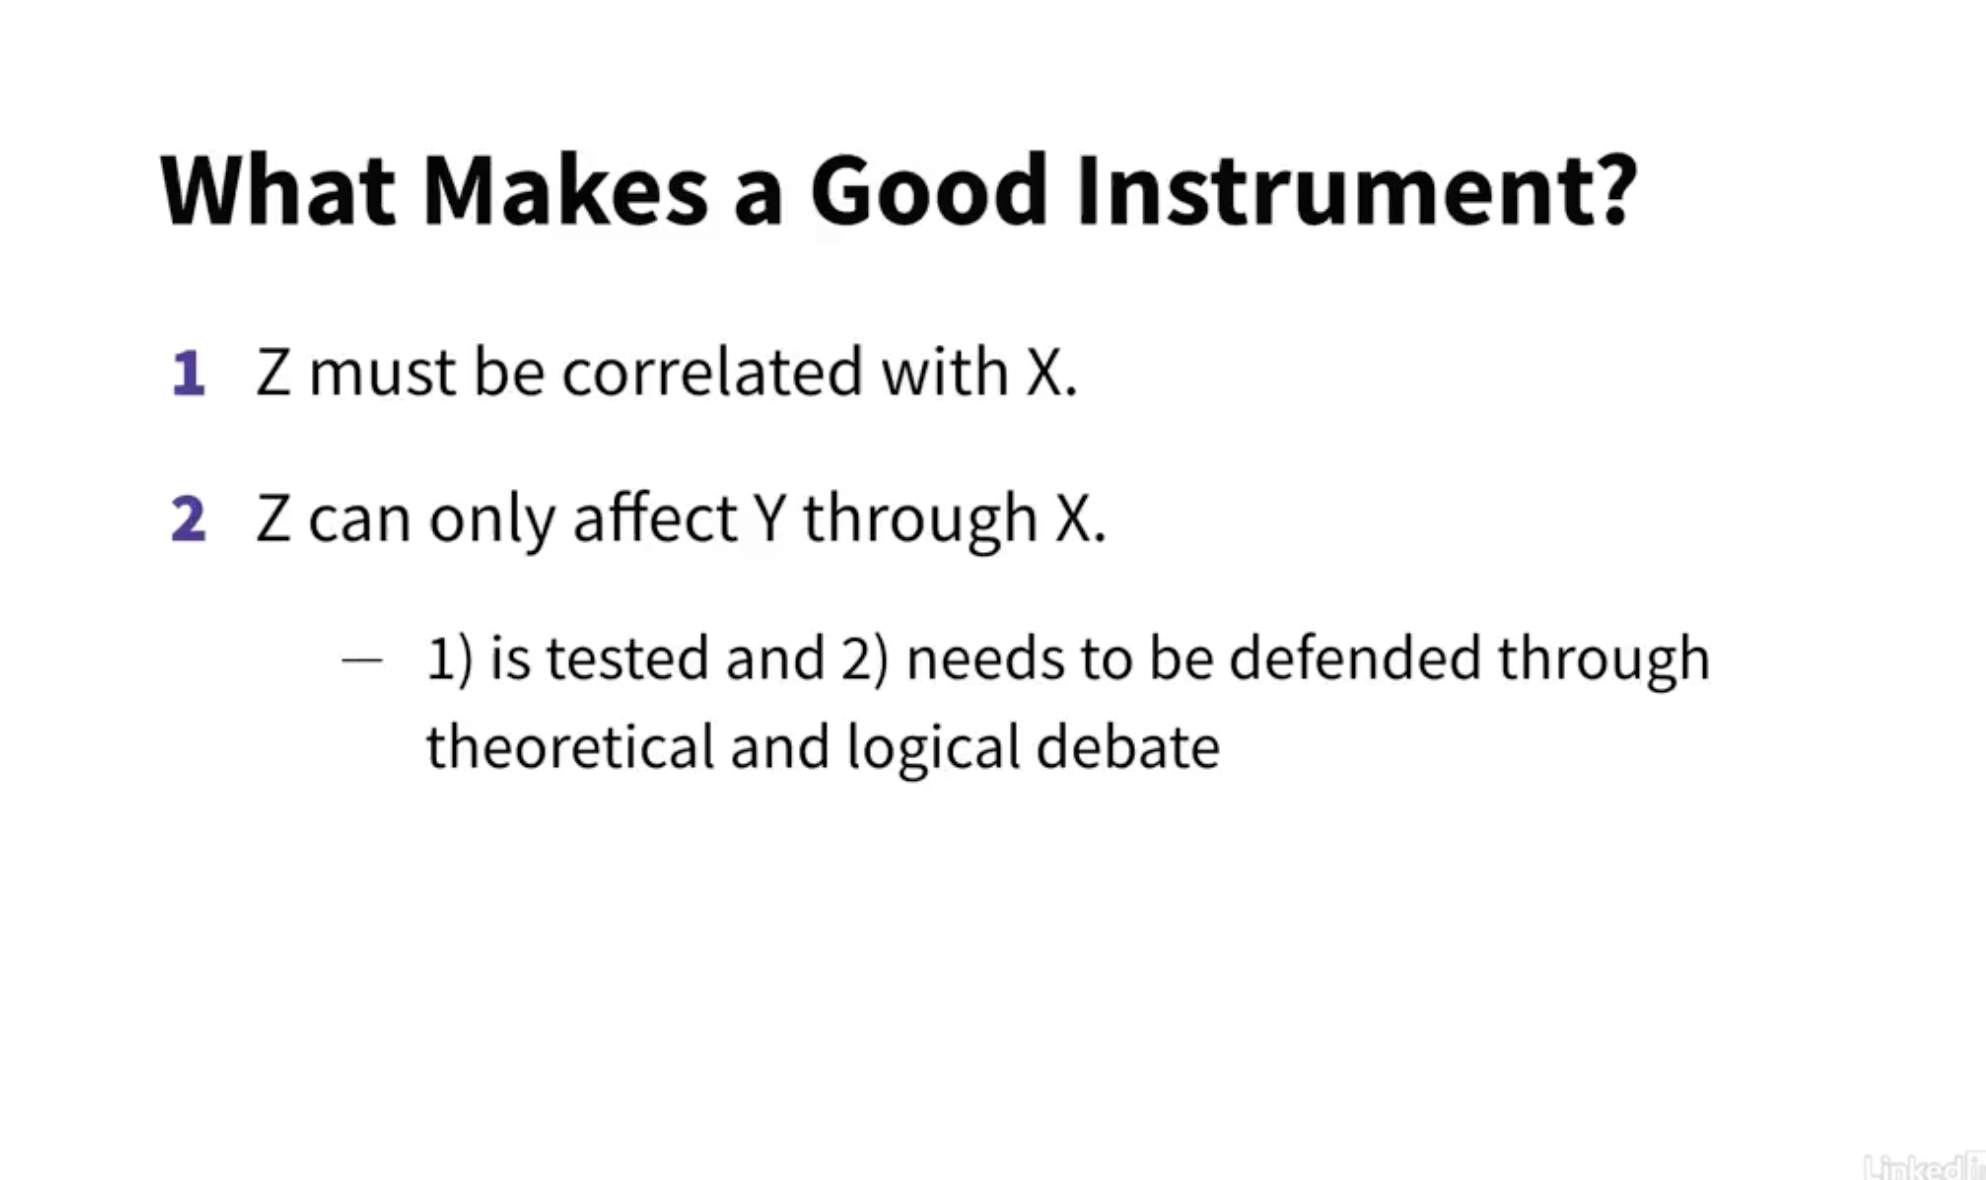


Examples of instruments in studies:
- distance to college
- lottery wins
- quarter of birth
- rainfall
- military draft lottery numbers



**Advantages**
- Identifies causal effect

**Disadvantages**
- Relies on having a good instrument (and good data quality to have an instrument)
- Applicable to local average treatment effect (only applicable to subset of individuals)

**Conclusion**
- Important causal technique for cross-sectional survey data
- Everything hinges on the instrument defense
- Not always possible, you may need to use other methods


In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 24 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

graphviz: 0.20.1

Watermark: 2.4.3

